# How to Handle Imbalanced Data Set for Classification Problems

## Introduction/Background of this experiment

I am developing a cost-based model performance metric so that  we can quantify the dollar benefit of a ML model to the customer.
Parallel to the cost metric, I'm also testing and developing different algorithms that can help us deal with imbalanced dataset.

There is an intersting article that talks about the framework for imbalanced classification projects.
https://machinelearningmastery.com/framework-for-imbalanced-classification-projects/
The purpose of this note book is to 
1. Test on a few treatments for imbalanced data. We will compare their performance and make recommedations on when a certain treatment might be more suitable
2. We also want to test the performance about Focal Loss https://arxiv.org/pdf/1708.02002.pdf, as well as our own customized cost function

In addition to achieve high performance metric, a good algorithm should be
1. Robust: perform well in different dataset, even the extreme cases
2. Adaptive: wide range of application, easy implementation
3. User Friendly: easy to use, meaning it is intuitive, and has less hyperparameters to turn
    
## Goal of this experiment
We want to 
1. Introduce cost metric as the primary  model valuation metric for external communications
2. Introduce robust solutions for handling imbalanced data, which can be thurther turned to result the lowest misclassification cost
3. Discuss
    - how the combination of class wieights and sample distribution might result in one algorithm more powerful than the others 
    - the importance of carefully chooseing misclassification weights




## Based on when we apply each algorithm or treatment during the learning process
### Pre-processing (Data Sampling Algorithms
common treatemnts are 
1. Over samplying on the minority class, such as SMOTE
    Synthetic Minority Over-sampling Technique as presented in [R001eabbe5dd7-1]
2. Under sampling on the majority class, such as random undersampling
    Under-sample the majority class(es) by randomly picking samples with or without replacement
3. Give the positive samples a weight
    sum(negative instances) / sum(positive instances)

### Customized Objective Function during training process
1. Cost function

2. ($\alpha$ balanced) Focal loss (https://arxiv.org/pdf/1708.02002.pdf)
$$FL(p_t) = −\alpha_t(1 − p_t)\gamma log(p_t). $$

### Post-processing (Probability Tuning Algorithms)
Vary decision threshold to find the decision point that will give us the optimal output base on the metrics we are looking for 

## Based on the business application and purpose of the use case, we could optimize
### Cost for misclassification 
if the cost is accessable from the clients or easy to infer. Or if the  For example,

### Imparcial recoganition on both classes, i.e., F1 Score, 
if both classes are important, or if it's hard to access costs from the clients. Improve the overall model performance will resulting in lower misclassification cost. However, if we know the cost of misclassification, or if the cost fopr misclassifications are far apart for different classes, we should directly optimize the cost instead.

## Design of this workbook

### Testing Data
We made a synthetic imbalanced data set by dropping the majority of the positive samples of the Bone-and-Joint deep dive data

### Method tested
0. Baseline model
    - Dummy classifier
    - Vanilla lightGBM
1. Pre-processing
    - SMOT(0.1) + random undersampling(0.5)
    - Pos_class_weights
2. Optimized objective function
    - Cost optimized
    - focal loss for f1 optimization
3. Post-processing
    - Change decisioon threshold on Vanilla lightGBM output to maximize F1/AUC
    - Change decisioon threshold on focal loss algorithm output to minimize cost

### Evaluation Metrics
- F1 (main metric)
- Cost of misclassification
- matthews corrlation coefficient https://www.researchgate.net/publication/338351315_The_advantages_of_the_Matthews_correlation_coefficient_MCC_over_F1_score_and_accuracy_in_binary_classification_evaluation
- AUC

In [49]:
import os
import pickle
import pandas as pd
import numpy as np
from numpy import where
from numpy import mean

from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold,ShuffleSplit

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
#from sklearn.preprocessing import MinMaxScaler
from imblearn.pipeline import Pipeline

from collections import Counter
#from sklearn.datasets import make_classification
from matplotlib import pyplot

import hyperopt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
import lightgbm as lgbm
from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict,ShuffleSplit
#from imblearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


NPSEED = 1337
np.random.seed(NPSEED)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Loading Data and Check Data Set

,sex_1,sex_2,admitAge,admitCategoryCode_1,admitCategoryCode_2,entryCode_1,entryCode_2,entryCode_3,entryCode_4,admitByAmbulanceCode_1,...,raDrugAlcoholAbuse,raObesity,raStroke,raMentalHealth,raHepatic,raAsthma,raRheumatoid,raHIV,raPneumonia,riskTotal
1,1,0,90.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1,0,81.0,1,0,1,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
3,1,0,72.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0
7,1,0,88.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
9,1,0,89.0,1,0,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


Data shape (11126, 103)


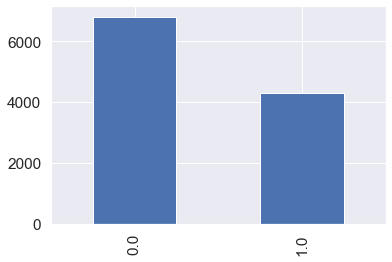

In [50]:
data = pickle.load(open('data/encoded_data.p','rb'))
display(data.head())
print(f"Data shape {data.shape}")
data['episodeDispositionCode'].value_counts().plot(kind='bar')
plt.show()
class_names =  ['Not continuing', 'Continuing Care']
features = list(data.keys())
features.remove('episodeDispositionCode')

In [3]:
data['episodeDispositionCode'].value_counts()

0.0    6807
1.0    4319
Name: episodeDispositionCode, dtype: int64

In [4]:
print('Features used:')
for feature in features:
    print(feature, end = ', ')

Features used:
sex_1, sex_2, admitAge, admitCategoryCode_1, admitCategoryCode_2, entryCode_1, entryCode_2, entryCode_3, entryCode_4, admitByAmbulanceCode_1, admitByAmbulanceCode_2, admitByAmbulanceCode_3, admitByAmbulanceCode_4, institutionZoneId_1, institutionZoneId_2, institutionZoneId_3, institutionZoneId_4, institutionZoneId_5, institutionZone_1, institutionZone_2, institutionZone_3, institutionZone_4, institutionZone_5, institutionTypeId_1, institutionTypeIdFrom_1, institutionTypeIdFrom_2, institutionTypeIdFrom_3, institutionTypeIdFrom_4, institutionTypeIdFrom_5, institutionTypeIdFrom_6, institutionTypeIdFrom_7, institutionTypeIdFrom_8, mainPatientService, mostRespDxCode_1, mostRespDxCode_2, mostRespDxCode_3, mostRespDxCode_4, mostRespDxCode_5, mostRespDxCode_6, mostRespDxCode_7, mostRespDxCode_8, mostRespDxCode_9, mostRespDxCode_10, mostRespDxCode_11, mostRespDxCode_12, mostRespDxCode_13, mostRespDxCode_14, mostRespDxCode_15, mostRespDxCode_16, mostRespDxCode_17, mostRespDxCode_1

### Create an imbalanced data set by dropping the majority of the positive samples

In [142]:
# Drop 95 of positive samples to create imbalanced data set

data_true = data.loc[data['episodeDispositionCode'] ==1].sample(frac=1).reset_index(drop=True)
data_false = data.loc[data['episodeDispositionCode'] ==0]
data_imbalance = pd.concat([data_true[:240], data_false], axis=0).sample(frac=1).reset_index(drop=True)


X_imbalance = data_imbalance.drop('episodeDispositionCode', axis=1)
y_imbalance = data_imbalance['episodeDispositionCode']
#random state used to be 42
X_train, X_test, y_train, y_test = train_test_split(X_imbalance, y_imbalance, test_size=0.20, random_state=42, stratify = y_imbalance)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=42, stratify = y_train)
feat_names = list(X_train.keys())


In [143]:
minority_proportion = sum(y_train==1)/len(y_train)
print('We made up an imbalanced data set where only ', np.round(minority_proportion,2)*100,' percent of sample is positive')
print(data_imbalance['episodeDispositionCode'].value_counts())


We made up an imbalanced data set where only  3.0  percent of sample is positive
0.0    6807
1.0     240
Name: episodeDispositionCode, dtype: int64


### Performance metric:

### For Cummunicate Business Value
- Cost of misclassification
- Benefit from correct classification
- Net benefit

### For Technical Matrix
- Confusion Matrix
- F1
- MCC
- AUC



### Conditions/Things to Test On
0. Assume positive class is the minority class
1. How imbalanced the dataset is? Minority class makes up to
    - 3%
    - 10%
    - 20%
    - 40% (balanced)
2. How does the cost of false minority class compared to cost of false majority class?
    - c_n >> c_p
    - c_n << c_p (does it even make sense?)
    - c_n ~ c_p  (is that just equivalent to maximizing F1 score?)


In [7]:
# Define technical performance metric

def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    class_names =  ['Not continuing', 'Continuing Care']    
    df_cm = pd.DataFrame(cm, columns=class_names, index = class_names)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},  fmt='d')
    plt.show()
    metrics = np.array( precision_recall_fscore_support(y_test, y_pred) )
    df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
    df_cm.index.name = 'Class'
    df_cm.columns.name = 'Metrics'
    display(df_cm)

In [8]:
# Define cost function for misclassifications

def Cost(y_pred, y_true, C_p, C_n):
    residual= (y_true - y_pred).astype("float")
    #print('Residual:\t',residual)
    loss = np.where(residual <=0, (residual**2)*C_p, residual**2*C_n)
    #print('Loss:\t',loss[:20])
    return np.mean(loss)

# Define Benefit function for correctly classify objectives
# We consider the scenario of churn prediction, where correctly identify positive cases means 
# capturing otherwise lost revenue at the expense of preventitive actions

def Benefit(y_true, B_p, B_n):
    
    benefit = np.where( y_true==1,1,0)*B_p+np.where( y_true==0,1,0)*B_n
    #print('Benefit:\t',benefit[:20])
    return np.mean(benefit)





In [84]:
# Define weights here
c_p=1
c_n=50
b_p=c_n-c_p
b_n=0

## Baseline Model -- The Dummy Classifier, and Default Model -- Vanilla LightGBM

In [144]:
# Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent",random_state=33).fit(X_train,y_train) 

y_pred_dummy = dummy_clf.predict(X_test) 
y_prob_dummy = dummy_clf.predict_proba(X_test)[:,1]
y_val_pred_dummy = dummy_clf.predict(X_valid)
y_val_prob_dummy = dummy_clf.predict_proba(X_valid)[:,1]

## The defualt is_unbalance = True/False as the objective parameter
## If we use as the objective parameter, the resulting model performed the same as setting scale_pos_weight
clf_default = lgbm.LGBMClassifier(is_unbalance=False,random_state=33,learning_rate=0.1, early_stopping_rounds = 10, n_estimators=10000)

clf_default.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=False)

y_pred_default = clf_default.predict(X_test)
y_prob_default = clf_default.predict_proba(X_test)[:,1]
y_val_pred_default = clf_default.predict(X_valid)
y_val_prob_default = clf_default.predict_proba(X_valid)[:,1]



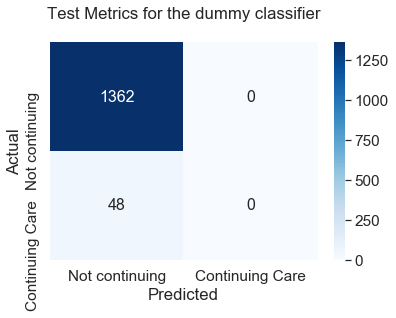

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.965957,0.0
Recall,1.000000,0.0
F,0.982684,0.0
Support,1362.000000,48.0


The matthews correlation coefficient is	 0.0
The cost of miscalssification under the dummy model is 	 1.7
The benefit of the dummy model is 	 1.67


/Users/jenwei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [145]:
plt.title('Test Metrics for the dummy classifier\n')
get_metrics(y_test, y_pred_dummy)
print('The matthews correlation coefficient is\t', matthews_corrcoef(y_test, y_pred_dummy))
print('The cost of miscalssification under the dummy model is \t',np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2))
print('The benefit of the dummy model is \t',np.round(Benefit(y_test,b_p, b_n),2))




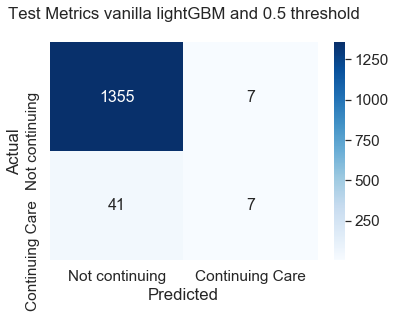

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.970630,0.500000
Recall,0.994860,0.145833
F,0.982596,0.225806
Support,1362.000000,48.000000


The matthews correlation coefficient is	 0.26
The cost of miscalssification under the default model is 	 1.46
The benefit of the default model is 	 1.67


In [147]:
plt.title('Test Metrics vanilla lightGBM and 0.5 threshold\n')
get_metrics(y_test, y_pred_default)
print('The matthews correlation coefficient is\t', np.round(matthews_corrcoef(y_test, y_pred_default),2))
print('The cost of miscalssification under the default model is \t',np.round(Cost(y_pred_default, y_test, c_p, c_n),2))
print('The benefit of the default model is \t',np.round(Benefit( y_test, b_p, b_n),2))




## Pre-processing Treatments
### 1. SMOTE combined with random under sampling 
### 2. Assign scales to positive class

In [148]:
## Use SMOTE + Random Undersapling method

# transform the imbalanced data set to balanced dataset
#oversample = SMOTE()
#X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)
#X_valid_SMOTE, y_valid_SMOTE = oversample.fit_resample(X_valid, y_valid)
# summarize the new class distribution
#print('Before transformation, the train set counter\t',Counter(y_train))
#print('After transformation, the train set counter\t',Counter(y_train_SMOTE))


# define pipeline
clf_prepross = lgbm.LGBMClassifier(is_unbalance=False,random_state=33,learning_rate=0.1, n_estimators=10000)
over = SMOTE(sampling_strategy = min(minority_proportion*3,0.5)) # Over sample to the 3*original proportion, or 30%
                                                                 # whichever is smaler

under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('clf_prepross', clf_prepross)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(pipeline, X_imbalance, y_imbalance, scoring='roc_auc', cv=cv, n_jobs=-1)
#print('Mean ROC AUC: %.3f' % mean(scores))

pipeline.fit(X_train, y_train)
y_pred_prepross = pipeline.predict(X_test)
y_prob_prepross = pipeline.predict_proba(X_test)[:,1]
y_val_pred_prepross = pipeline.predict(X_valid)
y_val_prob_prepross = pipeline.predict_proba(X_valid)[:,1]
print(classification_report(y_test, y_pred_prepross))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1362
         1.0       0.25      0.52      0.34        48

    accuracy                           0.93      1410
   macro avg       0.62      0.73      0.65      1410
weighted avg       0.96      0.93      0.94      1410



In [149]:
## Use iscale_pos_weight as the objective parameter
clf_scale = lgbm.LGBMClassifier(scale_pos_weight=len(y_train==0)/sum(y_train==1),
                                random_state=33,learning_rate=0.1, 
                                early_stopping_rounds = 10, n_estimators=10000)

clf_scale.fit(X_train,y_train,eval_set=[(X_valid, y_valid)],verbose=False)

y_pred_scale = clf_scale.predict(X_test)
y_prob_scale = clf_scale.predict_proba(X_test)[:,1]
y_val_pred_scale = clf_scale.predict(X_valid)
y_val_prob_scale = clf_scale.predict_proba(X_valid)[:,1]

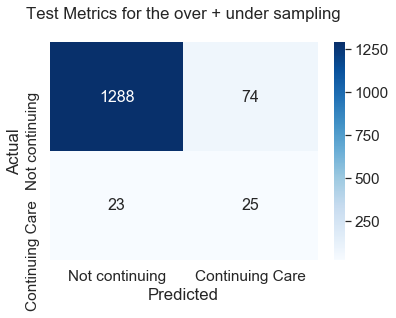

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.982456,0.252525
Recall,0.945668,0.520833
F,0.963711,0.340136
Support,1362.000000,48.000000


The matthews correlation coefficient is	 0.33
The cost of miscalssification under the dummy model is 	 0.87


In [150]:
plt.title('Test Metrics for the over + under sampling\n')
get_metrics(y_test, y_pred_prepross)
print('The matthews correlation coefficient is\t', np.round(matthews_corrcoef(y_test, y_pred_prepross),2))
print('The cost of miscalssification under the dummy model is \t',np.round(Cost(y_pred_prepross, y_test, c_p, c_n),2))




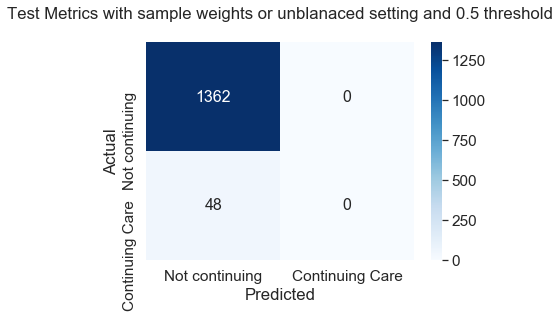

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.965957,0.0
Recall,1.000000,0.0
F,0.982684,0.0
Support,1362.000000,48.0


The MCC is	 0.0
The cost of miscalssification under the scale model is 	 1.7


/Users/jenwei/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [151]:
plt.title('Test Metrics with sample weights or unblanaced setting and 0.5 threshold\n')
get_metrics(y_test, y_pred_scale)
print('The MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_scale),2))
print('The cost of miscalssification under the scale model is \t',np.round(Cost(y_pred_scale, y_test, c_p, c_n),2))

## Customized Objective Function to Minimize 
### 1. Cost Function 
### 2. Focal Loss Function

In [152]:
# Define custom objective function -- Weighted Logistic Regression
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.misc import derivative

def weighted_loss_lgb_sk(y_true, y_pred, c_p, c_n):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray array with the predictions
    dtrain: lightgbm.Dataset
    c_p, c_n: float
    """
    sum = c_p+c_n
    c_p = c_p/sum
    c_n = c_n/sum
    
    def fl(x,t):
        #p = 1/(1+np.exp(-x))
        p = 1/(1+np.exp(-(x-.5)*2))
        return - ( c_n*t*np.log(p)+c_p*(1-t)*np.log(1-p) )

    
    partial_fl = lambda x: fl(x, y_true)
    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess



def weighted_loss_lgb_eval_error_sk(y_true, y_pred, c_p, c_n):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
     c_p, c_n: float
    """
 
    sum = c_p+c_n
    c_p = c_p/sum
    c_n = c_n/sum
    #p = 1/(1+np.exp(-y_pred))
    p = 1/(1+np.exp(-(y_pred-0.5)*2))
    loss = - ( c_n* y_true*np.log(p)+c_p*(1-y_true)*np.log(1-p) )
    return 'weighted_loss', np.mean(loss), False


In [153]:
# Focal loss function

def focal_loss_lgb_sk(y_true, y_pred, alpha, gamma):
    """
    Focal Loss for lightgbm

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    def fl(x,t):
        p = 1/(1+np.exp(-x))        
        return -( a*t + (1-a)*(1-t) ) * (( 1 - ( t*p + (1-t)*(1-p)) )**g) * ( t*np.log(p)+(1-t)*np.log(1-p) ) 
    partial_fl = lambda x: fl(x, y_true)

    grad = derivative(partial_fl, y_pred, n=1, dx=1e-6)
    hess = derivative(partial_fl, y_pred, n=2, dx=1e-6)
    return grad, hess



def focal_loss_lgb_eval_error_sk(y_true, y_pred, alpha, gamma):
    """
    Adapation of the Focal Loss for lightgbm to be used as evaluation loss

    Parameters:
    -----------
    y_pred: numpy.ndarray
        array with the predictions
    dtrain: lightgbm.Dataset
    alpha, gamma: float
        See original paper https://arxiv.org/pdf/1708.02002.pdf
    """
    a,g = alpha, gamma
    p = 1/(1+np.exp(-y_pred))
    loss = -( a*y_true + (1-a)*(1-y_true) ) * (( 1 - ( y_true*p + (1-y_true)*(1-p)) )**g) * ( y_true*np.log(p)+(1-y_true)*np.log(1-p) )
    return 'focal_loss', np.mean(loss), False

In [154]:
# Repredict y_pred_direct

# make new model on new value

#c_n=len(y_train)/sum(y_train==1)


weighted_loss = lambda x,y: weighted_loss_lgb_sk(x, y, c_p, c_n)
eval_error_weighted = lambda x,y: weighted_loss_lgb_eval_error_sk(x, y, c_p, c_n)
clf_direct = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= weighted_loss)


#altalab.wrap.lightgbm.LGBMClassification

clf_direct.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error_weighted,
    verbose=False,
)



y_pred_direct = clf_direct.predict(X_test)
y_prob_direct = clf_direct.predict_proba(X_test)[:,1]
y_val_pred_direct = clf_direct.predict(X_valid)
y_val_prob_direct = clf_direct.predict_proba(X_valid)[:,1]




In [166]:
# Repredict y_pred_fl

# make new model on new value
# Define alpha and gamma here

## The following parameters will produce higher F1 score for balanced data
#alpha=.25
#gamma=2

## The following parameters will produce higher F1 score for imbalanced data
alpha=.99
gamma=2


## The following parameters will produce higher recall 
## on the positive cases for imbalanced data
#alpha=.99
#gamma=1


focal_loss = lambda x,y: focal_loss_lgb_sk(x, y, alpha, gamma)
eval_error = lambda x,y: focal_loss_lgb_eval_error_sk(x, y, alpha,gamma)

clf_fl = lgbm.LGBMClassifier(random_state=33,
                                early_stopping_rounds = 10,
                                learning_rate=0.1,
                                n_estimators=10000,
                                objective= focal_loss)


clf_fl.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric=eval_error,
    verbose=False,
)


y_pred_fl = clf_fl.predict(X_test)
y_prob_fl = clf_fl.predict_proba(X_test)[:,1]
y_val_pred_fl = clf_fl.predict(X_valid)
y_val_prob_fl = clf_fl.predict_proba(X_valid)[:,1]


print('F1 score for the vaidation set of focal loss algorithm is\t',np.round(f1_score(y_valid, y_val_pred_fl),2))

F1 score for the vaidation set of focal loss algorithm is	 0.44


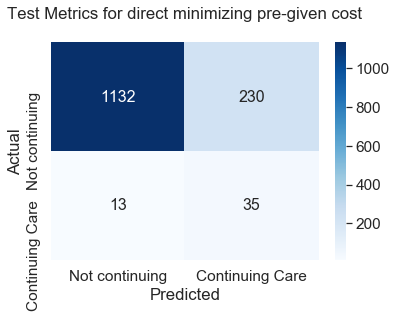

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.988646,0.132075
Recall,0.831131,0.729167
F,0.903071,0.223642
Support,1362.000000,48.000000


The MCC is	 0.26
The cost of miscalssification under the direct optimized model is 	 0.62


In [156]:
plt.title('Test Metrics for direct minimizing pre-given cost\n')
get_metrics(y_test, y_pred_direct)
print('The MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_direct),2)) 
print('The cost of miscalssification under the direct optimized model is \t',np.round(Cost(y_pred_direct, y_test, c_p, c_n),2))



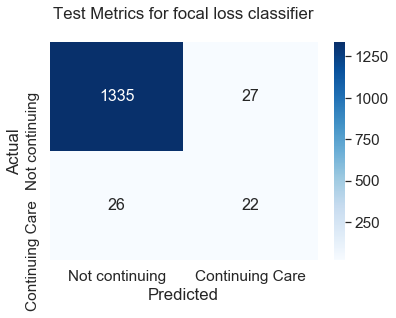

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.980896,0.448980
Recall,0.980176,0.458333
F,0.980536,0.453608
Support,1362.000000,48.000000


F1= 0.454 

The MCC is	 0.43
The cost of miscalssification under the focal loss model is 	 0.94


In [167]:
plt.title('Test Metrics for focal loss classifier\n')
get_metrics(y_test, y_pred_fl)
print('F1=',np.round(f1_score(y_test, y_pred_fl),3),'\n')
print('The MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_fl),2))
print('The cost of miscalssification under the focal loss model is \t',np.round(Cost(y_pred_fl, y_test, c_p, c_n),2))

## Post Processing -- Changing decision threshold

Note that there is no learning in this stage, this algorithm simply find the right level of conpromise for what you need to optimize.

Here, we consider two goals:
1. Reduce the cost associated with misclassification: minimize expected cost for misclassification
2. Achieve impartitial recogonition results on both classes: maximize F1 score
    
To this end, let us define two searching functions: 
1. GetMaxF1Threshold, and 
2. GetMinCostThreshold

It is trivial to include other metrics to optimize, as a proof of concept exercise, we only optimize F1 score or the cost for miscalssifications.    

In [130]:
## Varying threshold to find the highest F1 score
def GetMaxF1Threshold(y_true,y_pred,y_pred_prob):

    y_pred_cs = np.ones(y_true.shape)
    cmin = 999999
    vmax = -999999
    pmax = 0

    for theta in np.linspace(0,1,10):

        y_pred_cs = np.ones(y_pred.shape)
        y_pred_cs[y_pred_prob <= theta] = 0
        y_pred_cs[y_pred_prob > theta] = 1
   
        # Confusion metrix for each thredhold
        cm = confusion_matrix(y_true, y_pred_cs)
 

        class_names =  [ 'Continuing Care'] 
        metrics = np.array( precision_recall_fscore_support(y_true, y_pred_cs,beta=1,average ='binary') )
        #print('theta\t',theta,'matric\t',metrics,'\n')
    
        df_cm = pd.DataFrame(metrics, index=['Precision', 'Recall', 'F','Support'], columns = class_names)
        
        df_cm.index.name = 'Class'
        df_cm.columns.name = 'Metrics'
        #cost_to_be_mimimized = Cost(y_pred_cs, y_true, c_p, c_n)
        var_to_be_maximized =  metrics[2]
    

        if  vmax < var_to_be_maximized:
            vmax = (var_to_be_maximized)
            pmax = theta

    print(f'\n On the validation set, the best cutoffs F1 = {np.around(vmax,3)} for negative class <{np.around(pmax,2)},  and positive class >{np.around(pmax,2)}')

    return pmax,vmax


In [131]:
## Varying threshold to find the lowest misclassification cost
def GetMinCostThreshold(y_true,y_pred,y_pred_prob,c_p,c_n):

    y_pred_cs = np.ones(y_pred.shape)
    cmin = 999999
    vmax = -999999
    popt = 0

    for theta in np.linspace(0,1,10):

        y_pred_cs = np.ones(y_pred.shape)
        y_pred_cs[y_pred_prob <= theta] = 0
        y_pred_cs[y_pred_prob > theta] = 1
   
        cost_to_be_mimimized = Cost(y_pred_cs, y_true, c_p, c_n)
    
        if  cmin > cost_to_be_mimimized:
            cmin = cost_to_be_mimimized
            popt = theta

    print(f'\n On the validation set, the best cutoffs cost = {np.around(cmin,3)} for negative class <{np.around(popt,2)},  and positive class >{np.around(popt,2)}')

    return popt,cmin


#### Let us see how much the F1 score on Vanilla LightBGM can improve if we learn how to conpromise


 On the validation set, the best cutoffs F1 = 0.412 for negative class <0.22,  and positive class >0.22
Recall MCC is	 0.26  for the vanilla lightGBM
MCC can be improved to 0.39  when we add the change thredshold post processing treatment

Recall F1= 0.226  for the vanilla lightGBM
F1 can be improved to 0.409  when we add the change thredshold post processing treatment


 On the validation set, the best cutoffs cost = 0.915 for negative class <0.11,  and positive class >0.11
Recall the cost of miscalssification for vanilla LightGBM with 0.5 threshold is	 1.12
The mis classification cost can be reduced to 	 0.89 if we apply the optimal decision threshold



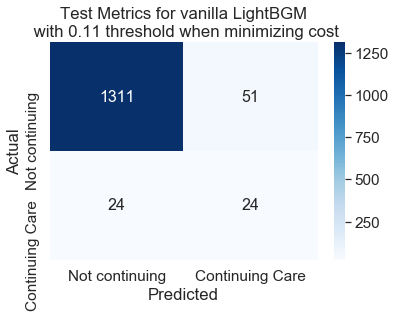

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.982022,0.320000
Recall,0.962555,0.500000
F,0.972191,0.390244
Support,1362.000000,48.000000


In [168]:
p_max_default, f1_max_default=GetMaxF1Threshold(y_valid,y_val_pred_default,y_val_prob_default)


print('Recall MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_default),2)," for the vanilla lightGBM")
print("MCC can be improved to", np.round(matthews_corrcoef(y_test, y_prob_default>p_max_default),2),' when we add the change thredshold post processing treatment\n')

print("Recall F1=",np.round(f1_score(y_test, y_pred_default),3)," for the vanilla lightGBM")
print("F1 can be improved to", np.round(f1_score(y_test, y_prob_default>p_max_default),3),' when we add the change thredshold post processing treatment\n')


p_min_default, cost_min_default=GetMinCostThreshold(y_valid,y_val_pred_default,y_val_prob_default,c_p,c_n)

print('Recall the cost of miscalssification for vanilla LightGBM with 0.5 threshold is\t',np.round(Cost(y_prob_default, y_test, c_p, c_n),2))
print('The mis classification cost can be reduced to \t',np.round(Cost(y_prob_default>p_min_default, y_test, c_p, c_n),2),'if we apply the optimal decision threshold\n')

plt.title(f'Test Metrics for vanilla LightBGM\n with {np.around(p_min_default,2)} threshold when minimizing cost')
get_metrics(y_test, y_prob_default>p_min_default)

## Combing post processing with pre-processing and customizing objective functions

Although the performance of the classifier can be improved if we further turn the decision threadhold, the purpose of this section is not to beat the performance metric up to death. Rather, we use post processing as an emporical test on how fully we have pushed the model performence by the other alogorithms.

#### Recall the F1 score for scaling the weight of positive samples provided by lightBGM was rather disappointing for our dataset. Let us see if post processing can do the resecure.


 On the validation set, the best cutoffs F1 = 0.441 for negative class <0.33,  and positive class >0.33


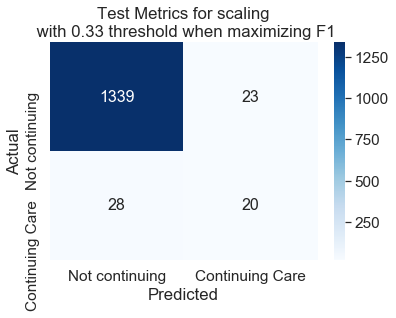

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.979517,0.465116
Recall,0.983113,0.416667
F,0.981312,0.439560
Support,1362.000000,48.000000


Recall MCC is	 0.0  for the scaling treatment
MCC can be improved to 0.38  when we add the change thredshold post processing treatment

Recall F1= 0.0  for the sample scaling treatment

F1 can be improved to 0.44  when we add the change thredshold post processing treatment



In [169]:
p_max_scale, f1_max_scale=GetMaxF1Threshold(y_valid,y_val_pred_scale,y_val_prob_scale)

plt.title(f'Test Metrics for scaling\n \
with {np.around(p_max_scale,2)} threshold when maximizing F1')
get_metrics(y_test, y_prob_scale>p_max_scale)

print('Recall MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_scale),2)," for the scaling treatment")
print("MCC can be improved to", np.round(matthews_corrcoef(y_test, y_prob_default>p_max_scale),2),' when we add the change thredshold post processing treatment\n')

print("Recall F1=",np.round(f1_score(y_test, y_pred_scale),3)," for the sample scaling treatment")
print("\nF1 can be improved to", np.round(f1_score(y_test, y_prob_scale>p_max_scale),3),' when we add the change thredshold post processing treatment\n')


 On the validation set, the best cutoffs F1 = 0.35 for negative class <0.67,  and positive class >0.67


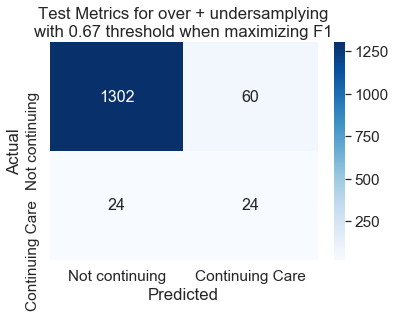

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.981900,0.285714
Recall,0.955947,0.500000
F,0.968750,0.363636
Support,1362.000000,48.000000


Recall MCC is	 0.33  for the over + under samplying pre-processing treatment
MCC can be improved to 0.16  when we add the change thredshold post processing treatment

Recall F1= 0.34  for the over + under samplying pre-processing treatment

F1 can be improved to 0.364  when we add the change thredshold post processing treatment



In [170]:
p_max_prepross, f1_max_prepross=GetMaxF1Threshold(y_valid,y_val_pred_prepross,y_val_prob_prepross)

plt.title(f'Test Metrics for over + undersamplying\n\
with {np.around(p_max_prepross,2)} threshold when maximizing F1')
get_metrics(y_test, y_prob_prepross>p_max_prepross)

print('Recall MCC is\t', np.round(matthews_corrcoef(y_test, y_pred_prepross),2)," for the over + under samplying pre-processing treatment")
print("MCC can be improved to", np.round(matthews_corrcoef(y_test, y_prob_default>p_max_prepross),2),' when we add the change thredshold post processing treatment\n')

print("Recall F1=",np.round(f1_score(y_test, y_pred_prepross),3)," for the over + under samplying pre-processing treatment")
print("\nF1 can be improved to", np.round(f1_score(y_test, y_prob_prepross>p_max_prepross),3),' when we add the change thredshold post processing treatment\n')
#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))



 On the validation set, the best cutoffs F1 = 0.441 for negative class <0.56,  and positive class >0.56


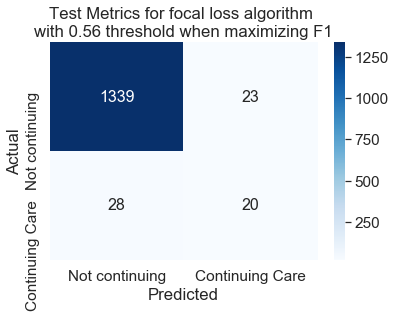

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.979517,0.465116
Recall,0.983113,0.416667
F,0.981312,0.439560
Support,1362.000000,48.000000


Recall F1= 0.454  for the focal loss algorithm

F1 can be improved to 0.44  when we add the change thredshold post processing treatment



In [171]:
p_max_fl, f1_max_fl=GetMaxF1Threshold(y_valid,y_val_pred_fl,y_val_prob_fl)
plt.title(f'Test Metrics for focal loss algorithm \n\
with {np.around(p_max_fl,2)} threshold when maximizing F1')
get_metrics(y_test, y_prob_fl>p_max_fl)

print("Recall F1=",np.round(f1_score(y_test, y_pred_fl),3)," for the focal loss algorithm")
print("\nF1 can be improved to", np.round(f1_score(y_test, y_prob_fl>p_max_fl),3),' when we add the change thredshold post processing treatment\n')
#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))



### Now let us see if post processing can further reduce the cost of the cost-optimized method


 On the validation set, the best cutoffs cost = 0.613 for negative class <0.0,  and positive class >0.0


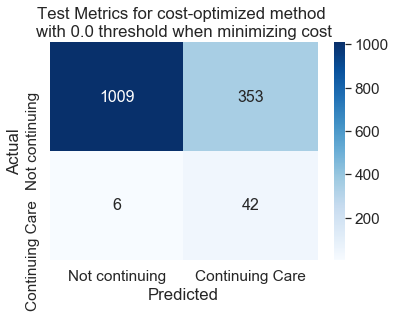

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.994089,0.106329
Recall,0.740822,0.875000
F,0.848969,0.189616
Support,1362.000000,48.000000


Recall Cost= 0.624  for the cost-optimized algorithm

Cost can be reduced to 0.463 when we add the change thredshold post processing treatment



In [172]:
p_min_direct, cost_min_direct=GetMinCostThreshold(y_valid,y_val_pred_direct,y_val_prob_direct,c_p,c_n)
plt.title(f'Test Metrics for cost-optimized method \n\
with {np.around(p_min_direct,2)} threshold when minimizing cost')
get_metrics(y_test, y_prob_direct>p_min_direct)

print("Recall Cost=",np.round(Cost(y_pred_direct,y_test,c_p,c_n),3)," for the cost-optimized algorithm")
print("\nCost can be reduced to", np.round(Cost(y_prob_direct>p_min_direct,y_test,c_p,c_n),3),'\
when we add the change thredshold post processing treatment\n')
#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))


### Conclusion: cost and F1 cannot be further improve via post-processing if the algorithm is already cost or F1 optimized.

### But can we further reduce the cost of focal loss algorithm if we varying the decision threashold?


 On the validation set, the best cutoffs cost = 0.481 for negative class <0.0,  and positive class >0.0


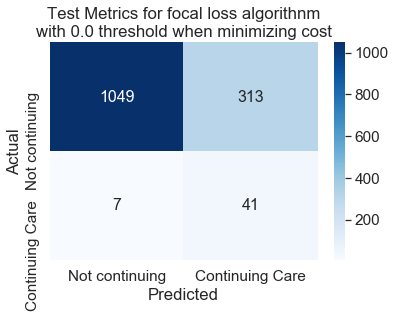

Metrics,Not continuing,Continuing Care
Class,,
Precision,0.993371,0.115819
Recall,0.770191,0.854167
F,0.867659,0.203980
Support,1362.000000,48.000000


Recall Cost= 0.941  for the focal loss algorithm

Cost can be reduced to 0.47  when we add the change thredshold post processing treatment



In [173]:
p_min_fl, cost_min_fl=GetMinCostThreshold(y_valid,y_val_pred_fl,y_val_prob_fl,c_p,c_n)
plt.title(f'Test Metrics for focal loss algorithnm\n\
with {np.around(p_min_fl,2)} threshold when minimizing cost')
get_metrics(y_test, y_prob_fl>p_min_fl)

print("Recall Cost=",np.round(Cost(y_pred_fl,y_test,c_p,c_n),3)," for the focal loss algorithm")
print("\nCost can be reduced to", np.round(Cost(y_prob_fl>p_min_fl,y_test,c_p,c_n),3),' when we add the change thredshold post processing treatment\n')
#print('The cost of miscalssification under the changing threshold method is \t',np.round(Cost(y_prob_prepross>p_max, y_test, c_p, c_n),2))


## Performance Comparison Summary

In [174]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Treatment/Algorithm", "MCC (\u2191)", "F1 (\u2191)", "Cost (\u2193)"]

x.add_row(["Dummy", np.round(matthews_corrcoef(y_test, y_pred_dummy),2), \
           np.round(f1_score(y_test, y_pred_dummy),2), np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2)])
x.add_row(["Vanilla lightGBM", np.round(matthews_corrcoef(y_test, y_pred_default),2), \
           np.round(f1_score(y_test, y_pred_default),2), np.round(Cost(y_pred_default, y_test, c_p, c_n),2)])
x.add_row(["Over + Under Sampling", np.round(matthews_corrcoef(y_test, y_pred_prepross),2), 
np.round(f1_score(y_test, y_pred_prepross),2), np.round(Cost(y_pred_prepross, y_test, c_p, c_n),2)])
x.add_row(["Scale", np.round(matthews_corrcoef(y_test, y_pred_scale),2), \
           np.round(f1_score(y_test, y_pred_scale),2), np.round(Cost(y_pred_scale, y_test, c_p, c_n),2)])
x.add_row(["Cost-optimized", np.round(matthews_corrcoef(y_test, y_pred_direct),2), \
           np.round(f1_score(y_test, y_pred_direct),2), np.round(Cost(y_pred_direct, y_test, c_p, c_n),2)])
x.add_row(["Focal Loss", np.round(matthews_corrcoef(y_test, y_pred_fl),2),\
           np.round(f1_score(y_test, y_pred_fl),2), np.round(Cost(y_pred_fl, y_test, c_p, c_n),2)])
x.add_row(["Post-pross + Vanilla", np.round(matthews_corrcoef(y_test, y_prob_default>p_max_default),2),\
           np.round(f1_score(y_test, y_prob_default>p_max_default),2), np.round(Cost(y_prob_default>p_min_default, y_test, c_p, c_n),2)])
x.add_row(["PostPross + Focal Loss", np.round(matthews_corrcoef(y_test, y_prob_fl>p_max_fl),2),\
           np.round(f1_score(y_test, y_prob_fl>p_max_fl),2), np.round(Cost(y_prob_fl>p_min_fl, y_test, c_p, c_n),2)])
print(x)

+------------------------+---------+--------+----------+
|  Treatment/Algorithm   | MCC (↑) | F1 (↑) | Cost (↓) |
+------------------------+---------+--------+----------+
|         Dummy          |   0.0   |  0.0   |   1.7    |
|    Vanilla lightGBM    |   0.26  |  0.23  |   1.46   |
| Over + Under Sampling  |   0.33  |  0.34  |   0.87   |
|         Scale          |   0.0   |  0.0   |   1.7    |
|     Cost-optimized     |   0.26  |  0.22  |   0.62   |
|       Focal Loss       |   0.43  |  0.45  |   0.94   |
|  Post-pross + Vanilla  |   0.39  |  0.41  |   0.89   |
| PostPross + Focal Loss |   0.42  |  0.44  |   0.47   |
+------------------------+---------+--------+----------+


In [175]:
x = PrettyTable()

x.field_names = ["Treatment/Algorith", "ROC_AUC (\u2191)", "Cost (\u2193)", \
                 "Net Benefit (\u2191)"]

x.add_row(["Dummy",  np.round(roc_auc_score(y_test, y_prob_dummy),2),\
           np.round(Cost(y_pred_dummy, y_test, c_p, c_n),2),\
           np.round( Benefit(y_test, b_p, b_n) - Cost(y_pred_dummy, y_test, c_p, c_n) ,2) ])

x.add_row(["Vanilla lightGBM",  np.round(roc_auc_score(y_test, y_prob_default),2), \
           np.round(Cost(y_pred_default, y_test, c_p, c_n),2),\
          np.round( Benefit(y_test, b_p, b_n) - Cost(y_pred_default, y_test, c_p, c_n)  ,2) ])

x.add_row(["Over + Under Sampling", np.round(roc_auc_score(y_test, y_prob_prepross),2), \
           np.round(Cost(y_pred_prepross, y_test, c_p, c_n),2),\
          np.round( Benefit(y_test, b_p, b_n) - Cost(y_pred_prepross, y_test, c_p, c_n)  ,2) ])

x.add_row(["Scale", np.round(roc_auc_score(y_test, y_prob_scale),2), \
           np.round(Cost(y_pred_scale, y_test, c_p, c_n),2),\
          np.round(Benefit(y_test, b_p, b_n) - Cost(y_pred_scale, y_test, c_p, c_n)  ,2) ])

x.add_row(["Cost-optimized", np.round(roc_auc_score(y_test, y_prob_direct),2), \
           np.round(Cost(y_pred_direct, y_test, c_p, c_n),2),\
          np.round(Benefit(y_test, b_p, b_n) - Cost(y_pred_direct, y_test, c_p, c_n)   ,2) ])

x.add_row(["Focal Loss", np.round(roc_auc_score(y_test, y_prob_fl),2), \
           np.round(Cost(y_pred_fl, y_test, c_p, c_n),2),\
          np.round( Benefit(y_test, b_p, b_n) - Cost(y_pred_fl, y_test, c_p, c_n)  ,2) ])

x.add_row(["Post-pross + Vanilla", np.round(roc_auc_score(y_test, y_prob_default),2), \
           np.round(Cost(y_prob_default>p_min_default, y_test, c_p, c_n),2), \
          np.round( Benefit(y_test, b_p, b_n) - Cost(y_prob_default>p_min_default, y_test, c_p, c_n) ,2) ])

x.add_row(["Focal Loss + PostPross", np.round(roc_auc_score(y_test, y_prob_fl),2), \
           np.round(Cost(y_prob_fl>p_min_fl, y_test, c_p, c_n),2), \
          np.round(Benefit(y_test, b_p, b_n) - Cost(y_prob_fl>p_min_fl, y_test, c_p, c_n),2) ])

print(x)





+------------------------+-------------+----------+-----------------+
|   Treatment/Algorith   | ROC_AUC (↑) | Cost (↓) | Net Benefit (↑) |
+------------------------+-------------+----------+-----------------+
|         Dummy          |     0.5     |   1.7    |      -0.03      |
|    Vanilla lightGBM    |     0.89    |   1.46   |       0.21      |
| Over + Under Sampling  |     0.87    |   0.87   |       0.8       |
|         Scale          |     0.82    |   1.7    |      -0.03      |
|     Cost-optimized     |     0.86    |   0.62   |       1.04      |
|       Focal Loss       |     0.86    |   0.94   |       0.73      |
|  Post-pross + Vanilla  |     0.89    |   0.89   |       0.78      |
| Focal Loss + PostPross |     0.86    |   0.47   |       1.2       |
+------------------------+-------------+----------+-----------------+


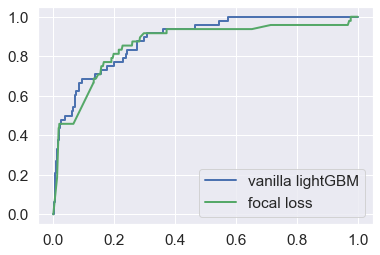

In [176]:

label='vanilla'
color='b'

fpr, tpr, thresholds = roc_curve(y_test, y_prob_default, pos_label=1)
roc_auc = auc(fpr, tpr)

roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)
line_up, =plt.plot(fpr, tpr, color=color, linewidth=2, label='vanilla')



label='fl'
color='g'

fpr, tpr, thresholds = roc_curve(y_test, y_prob_fl, pos_label=1)
roc_auc = auc(fpr, tpr)

roc_label = '{} (AUC={:.3f})'.format(label, roc_auc)
line_down, = plt.plot(fpr, tpr, color=color, linewidth=2, label='fl')

plt.legend([line_up, line_down], ['vanilla lightGBM', 'focal loss'])
plt.show()

## Conclusion and Takeawys

### Conclusion on model performance
1.


### Recommendations on 
1. My go-to treatment is the changing threshold method. It's simply and versatile, although there is no gain in the proediction power 
